# Unsupervised Decision-Support Framework for Athlete Monitoring
## Notebook 6: Synthetic Data Augmentation & Sensitivity Validation

**Authors:** Fernando Barcelos Rosito, Sebastião De Jesus Menezes,Simone Ferreira Sturza, Adriana Seixas, Muriel Figueredo Franco
**Associated Paper:** *An Unsupervised Decision-Support Framework for Multivariate Biomarker Analysis in Athlete Monitoring* (Submitted, 2026).

---

### Objective
This notebook operationalizes the **Sensitivity Validation** phase described in the paper.
1. **Synthetic Seed Construction:** We manually construct a seed dataset ($n=15$) representing distinct physiological profiles, including a latent **"Silent Risk"** phenotype characterized by metabolic stress (High Insulin/Homocysteine) but normal standard markers (CK/Cortisol).
2. **Data Augmentation:** We employ a **Regularized Gaussian Mixture Model (GMM)** to expand this seed into a larger cohort ($n=290$).
   - *Note:* We use structural constraints (`covariance_type='diag'` and `reg_covar=0.1`) to ensure statistical stability given the high dimensionality ($b=32$) relative to the seed size.
3. **Cluster Recovery:** We apply Unsupervised Learning (K-Means/Ward) to verify if the algorithm can successfully recover the injected "Silent Risk" profile from the noisy, augmented dataset.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seaborn style setup
sns.set(style="whitegrid")

# REPRODUCIBILITY SETUP
# We set a fixed random seed to ensure that the synthetic data generation
# and clustering results are exactly reproducible as reported in the manuscript.
RANDOM_SEED = 6
np.random.seed(RANDOM_SEED)

print("Libraries loaded and random seed set to:", RANDOM_SEED)

Libraries loaded and random seed set to: 6


## 1. GMM-Based Augmentation Engine

To address the challenge of small sample sizes ($n=15$) in high-dimensional space ($d=32$), we define the function `generate_synthetic_athletes`.
This function implements the **Robust GMM** methodology proposed in the paper.

**Methodological Highlights:**
1.  **Input:** A "Seed Dataset" containing the prototypical physiological profiles (including the latent "Silent Risk" phenotype).
2.  **Structural Constraints:**
    * `covariance_type='diag'`: Assumes conditional independence of biomarkers within clusters to reduce the number of parameters estimated.
    * `reg_covar=0.1`: Adds regularization to the diagonal of the covariance matrix. This prevents overfitting and singularity issues common when $n < d$ (The Curse of Dimensionality).
3.  **Output:** A synthetic cohort ($n=290$) that retains the statistical properties of the seed without memorizing the exact data points.

In [ ]:
def generate_synthetic_athletes(seed_file_path, output_file_path, n_components=5, ratio=10):
    """
    Expands a small seed dataset using a Regularized Gaussian Mixture Model.

    Parameters:
    - seed_file_path: Path to the seed CSV (n=15).
    - output_file_path: Path to save the augmented dataset.
    - n_components: Number of expected physiological profiles (Clusters).
    - ratio: Target ratio (Variables * 10).
    """
    print(f"\n--- Processing Seed: {seed_file_path} ---")
    
    try:
        df = pd.read_csv(seed_file_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo {seed_file_path} não encontrado.")
        return

    df_clean = df.copy()
    
    # 1. Pre-processing: Handling Brazilian format (comma decimals) if present
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object' and col not in ['Nome', 'Posicao']:
            # Replaces comma with dot for float conversion
            df_clean[col] = df_clean[col].str.replace(',', '.').astype(float, errors='ignore')

    # 2. Feature Selection: Numeric biomarkers only
    df_biomarkers = df_clean.select_dtypes(include=[np.number])

    # Exclude non-biological features (IDs, numbers, existing cluster labels)
    cols_ignorar = ['Numero', 'Número', 'ID']
    df_biomarkers = df_biomarkers.drop(columns=[c for c in cols_ignorar if c in df_biomarkers.columns], errors='ignore')
    
    # Fill initial NaNs with median (Critical for GMM stability)
    df_biomarkers = df_biomarkers.fillna(df_biomarkers.median())

    # 3. Augmentation Goal Calculation (Rule of 10:1)
    n_features = df_biomarkers.shape[1]
    current_n = df_biomarkers.shape[0]
    target_n = n_features * ratio
    n_to_generate = target_n - current_n
    
    print(f"Biomarkers detected: {n_features}")
    print(f"Current Seed Size: {current_n}")
    print(f"Target Cohort Size (10:1 ratio): {target_n}")
    
    if n_to_generate <= 0:
        print("Target ratio already met.")
        return

    print(f"Generating {n_to_generate} synthetic profiles using Robust GMM (k={n_components})...")

    # 4. GMM TRAINING (The Core Methodology)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_biomarkers)
    
    # NOTE: covariance_type='diag' and reg_covar=0.1 are the key constraints
    gmm = GaussianMixture(
        n_components=n_components,
        random_state=42,
        reg_covar=0.1,          # Defense against singularity
        covariance_type='diag'  # Defense against overfitting
    )
    gmm.fit(X_scaled)
    
    # 5. Sampling (Generation)
    X_new_scaled, _ = gmm.sample(n_to_generate)
    X_new = scaler.inverse_transform(X_new_scaled)
    
    df_new = pd.DataFrame(X_new, columns=df_biomarkers.columns)
    
    # Safety Clip: Biomarkers cannot be negative
    df_new[df_new < 0] = 0.1
    
    # Tagging synthetic data
    df_new['Nome'] = [f'Extra_Sintetico_{i+1:03d}' for i in range(n_to_generate)]
    df_new['Tipo_Dado'] = 'Sintético'
    
    df_original = df_clean.copy()
    df_original['Tipo_Dado'] = 'Real'
    
    # Merge and Save
    df_final = pd.concat([df_original, df_new], ignore_index=True)
    df_final.to_csv(output_file_path, index=False)
    print(f"Success! Augmented dataset '{output_file_path}' created with {len(df_final)} profiles.")

# --- EXECUTION FLOW ---

# SECURITY NOTE: We use the synthetic seed file to ensure privacy compliance.
# The structure mirrors the real-world dataset used in the study.
filename = '../database/dataset_example_structure'

# 1. Run the Augmentation Engine
# Arguments: Input File, Output File, Number of Profiles (k=5)
generate_synthetic_athletes('dataset_example_structure.csv', 'dados_extras_aumentado.csv', n_components=5)

# 2. Load the Augmented Cohort
print("\n--- Loading Augmented Cohort for Analysis ---")
df = pd.read_csv('dados_extras_aumentado.csv')

# 3. Unit Conversion & Standardization
# Converting Testosterone from nmol/L to ng/dL (Clinical Standard)
# We search for columns containing 'Testosterona' (Portuguese source)
testosterone_cols = [col for col in df.columns if 'Testosterona' in col and 'nmol/L' in col]
conversion_factor = 28.8

for col in testosterone_cols:
    df[col] = df[col] * conversion_factor
    # Rename to English: Testosterona -> Testosterone
    new_name = col.replace('(nmol/L)', '(ng/dL)')
    df = df.rename(columns={col: new_name})
    print(f"Converted and Renamed: {col} -> {new_name}")

# 4. Final Feature Matrix Preparation
# Define metadata columns to exclude (Supporting both Portuguese and English tags)
cols_to_drop = ['Nome', 'Posicao', 'Numero', 'Cluster', 'Tipo_Dado']
X = df.drop(columns=cols_to_drop, errors='ignore')

# Ensuring numeric integrity (Select only numbers and fill NaNs)
X = X.select_dtypes(include=[np.number])
X = X.fillna(X.mean())

# 5. Global Scaling (Standardization)
# Essential for distance-based algorithms like K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData Ready. Final Matrix Shape for Modeling: {X_scaled.shape}")


--- Processing Seed: dados_extras.csv ---
Biomarkers detected: 29
Current Seed Size: 15
Target Cohort Size (10:1 ratio): 290
Generating 275 synthetic profiles using Robust GMM (k=5)...
Success! Augmented dataset 'dados_extras_aumentado.csv' created with 290 profiles.

--- Loading Augmented Cohort for Analysis ---
Converted and Renamed: Testosterona (nmol/L) -> Testosterona (ng/dL)
Converted and Renamed: Testosterona 24h (nmol/L) -> Testosterona 24h (ng/dL)
Converted and Renamed: Testosterona T Pré (nmol/L) -> Testosterona T Pré (ng/dL)

Data Ready. Final Matrix Shape for Modeling: (290, 29)


## 2. Structural Inspection (Hierarchical Clustering)

Before applying K-Means, we utilize **Hierarchical Clustering (Ward's Method)** to visually inspect the structure of the augmented cohort ($n=290$).

**Objectives:**
1.  **Dendrogram Analysis:** Visualize the branching structure to confirm if distinct physiological groups are emerging (we expect ~5 main branches).
2.  **Outlier Detection:** Identify if any synthetic sample deviates excessively from the population (long vertical lines), which would indicate a generation artifact.

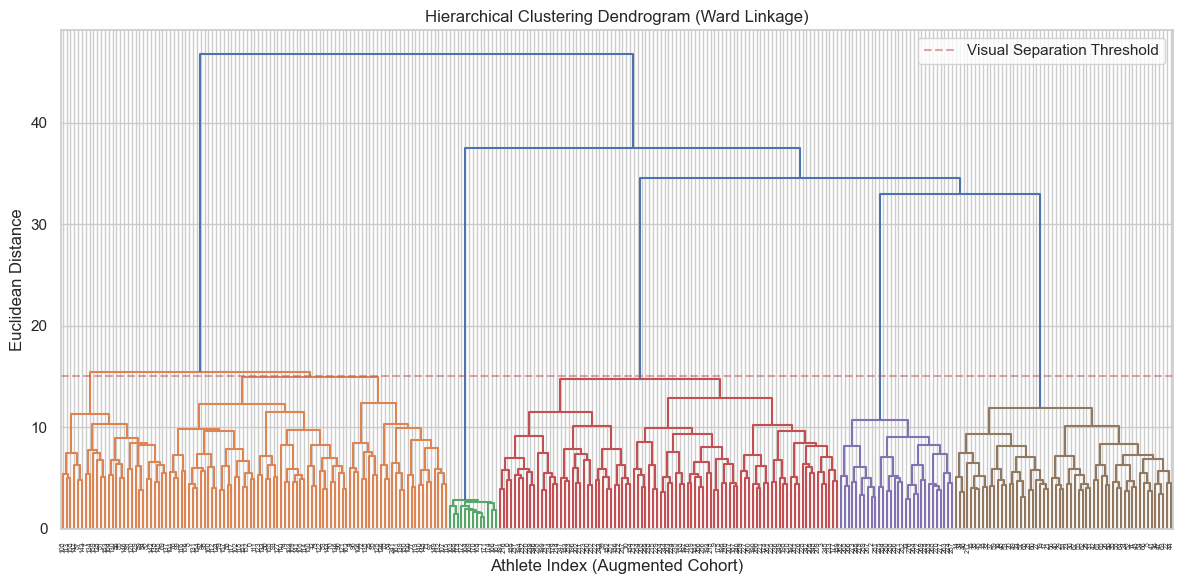

Total athletes ready for K-Means Clustering: 290


In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage

# --- HIERARCHICAL CLUSTERING & VISUALIZATION ---

plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")

# 'ward' minimizes the variance of the clusters being merged.
linkage_matrix = linkage(X_scaled, method='ward')

dendro = dendrogram(linkage_matrix)

plt.xlabel("Athlete Index (Augmented Cohort)")
plt.ylabel("Euclidean Distance")

# Visual Threshold (Optional: Adjust based on visual inspection)
# A horizontal line helps visualization of where the 'cut' would be for k clusters
plt.axhline(y=15, color='r', linestyle='--', alpha=0.5, label='Visual Separation Threshold')

plt.legend()
plt.tight_layout()
plt.show()

# --- PREPARATION FOR K-MEANS ---

# In this validation workflow, we generally retain all synthetic samples 
# unless extreme outliers are detected in the dendrogram above.
df_clean = df.copy()
X_final = X.copy()       # Feature matrix for clustering

# Re-fitting scaler (Ensure consistency before K-Means)
X_scaled_final = scaler.fit_transform(X_final)

print(f"Total athletes ready for K-Means Clustering: {len(df_clean)}")

## 3. Multi-Granularity Analysis: Decision Support Scenarios

The framework allows for hierarchical decision-making by adjusting the clustering resolution ($k$). Here, we simulate two operational scenarios described in the paper:

1.  **Macro-Management ($k=3$):** Designed for Head Coaches.
    * Simplifies the cohort into broad categories (e.g., *Ready*, *Fatigued*, *High Risk*).
2.  **Micro-Management ($k=5$ - Sensitivity Validation):** Designed for Physiologists/Sports Scientists.
    * Granular view to detect specific etiologies.
    * **Goal:** Successfully isolate the **"Silent Risk"** phenotype (High Insulin/Homocysteine) distinct from mechanical fatigue.


>> PROCESSING SCENARIO: K=3...


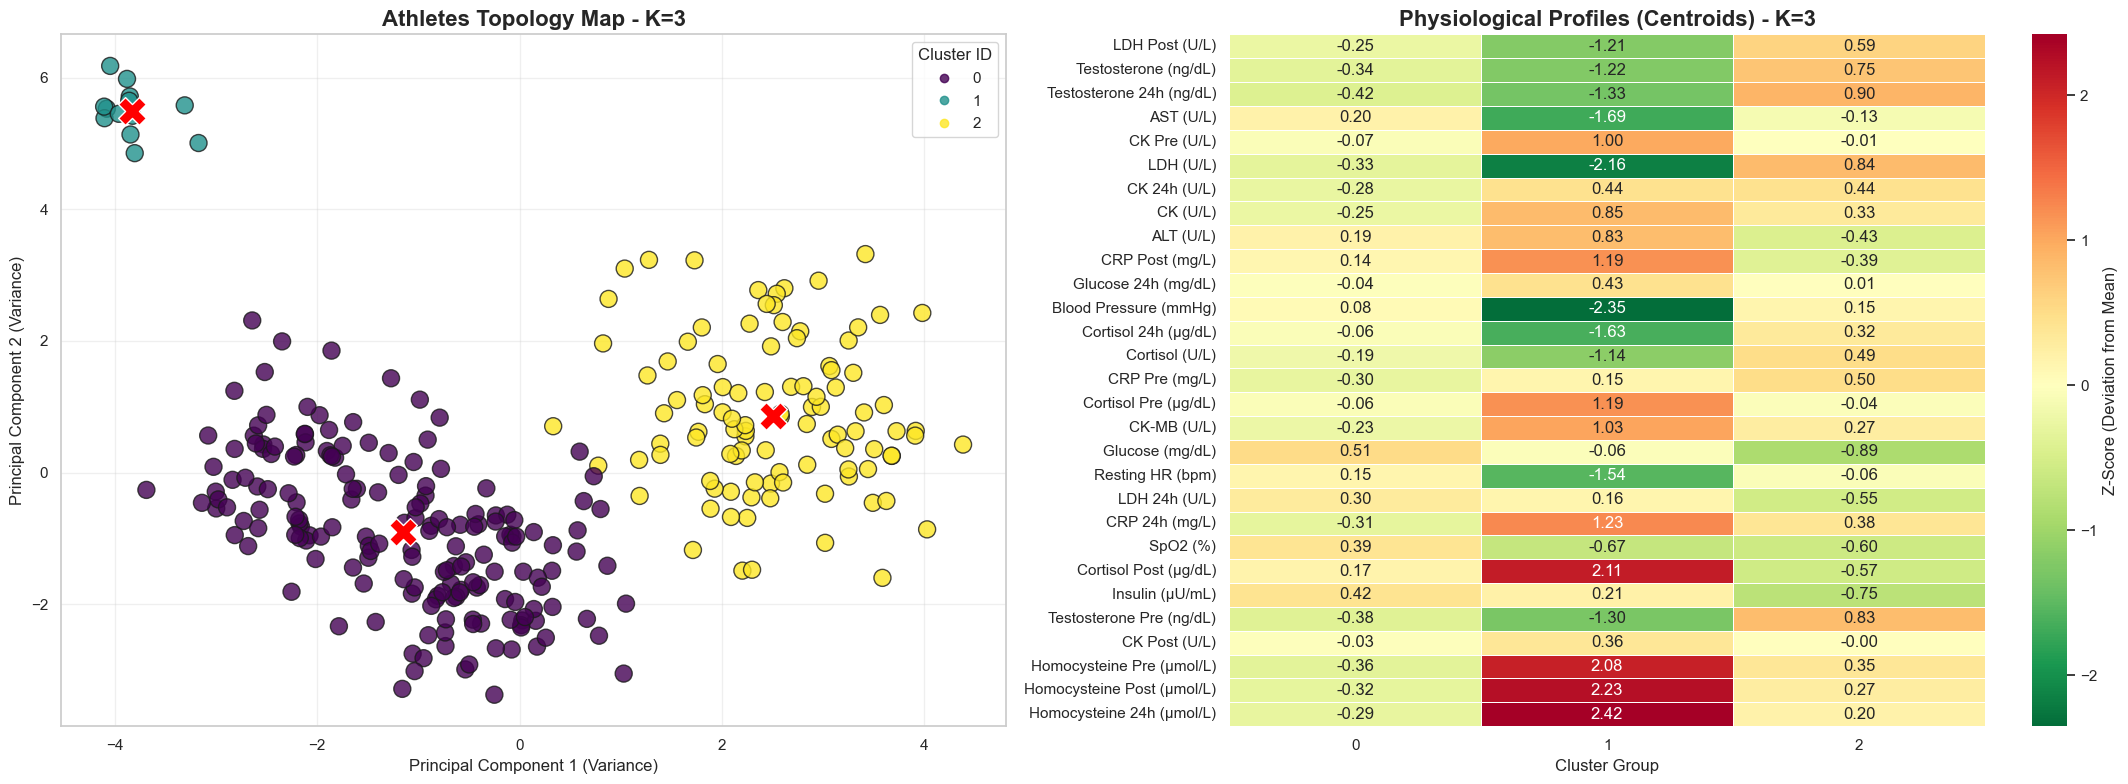

Distribution of Athletes (K=3):
0    176
1     13
2    101
Name: count, dtype: int64
--------------------------------------------------

>> PROCESSING SCENARIO: K=5...


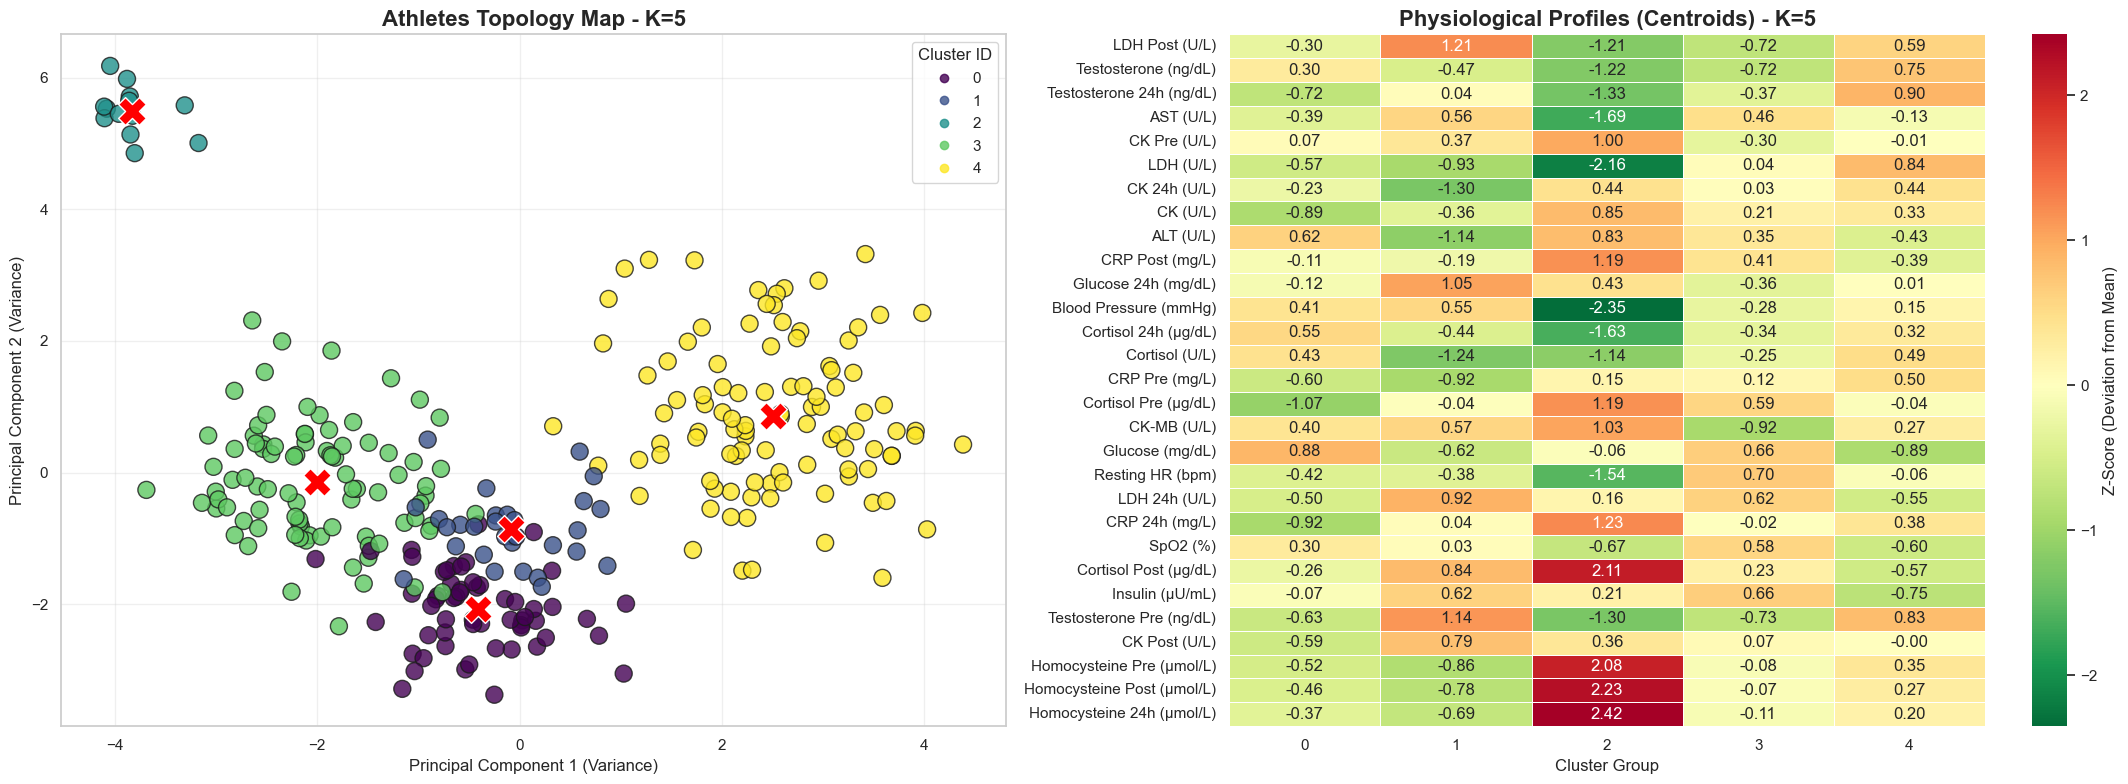

Distribution of Athletes (K=5):
0     58
1     30
2     13
3     88
4    101
Name: count, dtype: int64
--------------------------------------------------

--- Validation Summary ---
Analysis complete. Check the K=5 Heatmap above to confirm the presence of:
1. A 'Mechanical Damage' cluster (High CK/LDH)
2. A 'Silent Risk' cluster (High Insulin/Homocysteine, Normal CK)


In [7]:
# --- 1. VISUALIZATION DICTIONARY (Translation & Formatting) ---
# Maps raw column names (PT/Source) to Publication-Ready English labels
translation_map = {
    # --- CARDIOVASCULAR ---
    'FC Repouso (bpm)': 'Resting HR (bpm)',
    'Pressão (mmHG)': 'Blood Pressure (mmHg)',
    'Oximetria (SpO2)': 'SpO2 (%)',
    
    # --- MUSCLE DAMAGE & ENZYMES ---
    # CK (Creatina Quinase)
    'CPK Pré (U/L)': 'CK Pre (U/L)',
    'CPK Pós (U/L)': 'CK Post (U/L)',
    'CPK 24h (U/L)': 'CK 24h (U/L)',
    'CPK (U/L)': 'CK (U/L)',
    'CK-MB (U/L)': 'CK-MB (U/L)',
    
    # LDH (Lactato Desidrogenase)
    'LDH (U/L)': 'LDH (U/L)',
    'LDH Pós (U/L)': 'LDH Post (U/L)',
    'LDH 24h (U/L)': 'LDH 24h (U/L)',
    
    # --- LIVER FUNCTION ---
    'TGO (U/L)': 'AST (U/L)',
    'TGP (U/L)': 'ALT (U/L)',

    # --- INFLAMMATION ---
    # CRP (C-reactive protein)
    'PCR Pré (mg/L)': 'CRP Pre (mg/L)',
    'PCR Pós (mg/L)': 'CRP Post (mg/L)',
    'PCR 24h Pós (mg/L)': 'CRP 24h (mg/L)',

    # --- HORMONAL ---
    # Testosterone
    'Testosterona T Pré (ng/dL)': 'Testosterone Pre (ng/dL)',
    'Testosterona (ng/dL)': 'Testosterone (ng/dL)',
    'Testosterona 24h (ng/dL)': 'Testosterone 24h (ng/dL)',

    # Cortisol
    'Cortisol Pré (µg/dL)': 'Cortisol Pre (µg/dL)',
    'Cortisol Pós (µg/dL)': 'Cortisol Post (µg/dL)',
    'Cortisol 24h (µg/dL)': 'Cortisol 24h (µg/dL)',
    'Cortisol (U/L)': 'Cortisol (U/L)',

    # --- METABOLIC ---
    # Insulin and Glucose
    'Insulina (µU/mL)': 'Insulin (µU/mL)',
    'Glicose (mg/dL)': 'Glucose (mg/dL)',
    'Glicose 24h (mg/dL)': 'Glucose 24h (mg/dL)',
    
    # Homocysteine
    'Homocisteína pré (µmol/L)': 'Homocysteine Pre (µmol/L)',
    'Homocisteína pós (µmol/L)': 'Homocysteine Post (µmol/L)',
    'Homocisteína 24h (µmol/L)': 'Homocysteine 24h (µmol/L)'
}

# --- 2. CLUSTERING & VISUALIZATION FUNCTION ---
def run_clustering_scenario(k, X_data, scenario_title, feature_columns):
    """
    Executes K-Means, computes centroids, and generates the Decision Support Dashboard.
    """
    print(f"\n>> PROCESSING SCENARIO: {scenario_title}...")

    # 1. K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_data)
    
    # 2. PCA for 2D Visualization (Map of Athletes)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    
    # 3. PLOTTING
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Plot A: Scatter Map
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=150, edgecolors='k', alpha=0.8)
    ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=400, c='red', marker='X', label='Centroids', edgecolors='white')

    ax1.set_title(f'Athletes Topology Map - {scenario_title}', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Principal Component 1 (Variance)')
    ax1.set_ylabel('Principal Component 2 (Variance)')
    ax1.legend(*scatter.legend_elements(), title="Cluster ID")
    ax1.grid(True, alpha=0.3)

    # Plot B: Physiological Heatmap (Z-Scores)
    # Create temporary DF for visualization only
    df_vis = pd.DataFrame(X_data, columns=feature_columns)
    
    # Translate columns for the plot using the dictionary
    # Uses original name if not found in dictionary
    df_vis = df_vis.rename(columns=translation_map)

    df_vis['Cluster'] = labels
    avg_profile = df_vis.groupby('Cluster').mean()
    
    sns.heatmap(avg_profile.T, ax=ax2, cmap='RdYlGn_r', center=0, annot=True, fmt='.2f', 
                linewidths=0.5, cbar_kws={'label': 'Z-Score (Deviation from Mean)'})
    
    ax2.set_title(f'Physiological Profiles (Centroids) - {scenario_title}', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Cluster Group')
    
    plt.tight_layout()
    plt.show()
    
    # Distribution Stats
    print(f"Distribution of Athletes ({scenario_title}):")
    print(pd.Series(labels).value_counts().sort_index())
    print("-" * 50)
    
    return labels

# --- 3. EXECUTING SCENARIOS ---

# We use 'df_clean' from the previous step to store results
# We use 'X_scaled_final' for the math (from the step right after dendrogram)

# Scenario A: K=3 (Coach View)
# Simplification for macro-management
df_clean['Cluster_K3'] = run_clustering_scenario(3, X_scaled_final, "K=3", X.columns)

# Scenario B: K=5 (Physiologist View - Validation)
# Granular view to detect the "Silent Risk"
df_clean['Cluster_K5'] = run_clustering_scenario(5, X_scaled_final, "K=5", X.columns)

print("\n--- Validation Summary ---")
print("Analysis complete. Check the K=5 Heatmap above to confirm the presence of:")
print("1. A 'Mechanical Damage' cluster (High CK/LDH)")
print("2. A 'Silent Risk' cluster (High Insulin/Homocysteine, Normal CK)")